In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,average_precision_score,fbeta_score,roc_curve,auc,classification_report
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
test_id=test['ID']

In [3]:
print('Training data shape:',df.shape)
print('Test Data Shape:',test.shape)#so many features, we have to omit insignificant feature

Training data shape: (76020, 371)
Test Data Shape: (75818, 370)


In [4]:
df.head()#target is the response variable

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


percentage of target 1: 3.9568534596158904


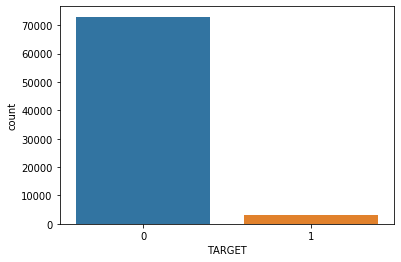

In [5]:
print('percentage of target 1:',df['TARGET'].sum()*100/df['TARGET'].count())
sns.countplot(df['TARGET'])
#highly imbalaced data

In [6]:
col=[]#col where data in that particular columns has no variation , obviously they will not impact in response variable
for i in (df.columns):
    if df[i].std()==0:
        col.append(i)
col

['ind_var2_0',
 'ind_var2',
 'ind_var27_0',
 'ind_var28_0',
 'ind_var28',
 'ind_var27',
 'ind_var41',
 'ind_var46_0',
 'ind_var46',
 'num_var27_0',
 'num_var28_0',
 'num_var28',
 'num_var27',
 'num_var41',
 'num_var46_0',
 'num_var46',
 'saldo_var28',
 'saldo_var27',
 'saldo_var41',
 'saldo_var46',
 'imp_amort_var18_hace3',
 'imp_amort_var34_hace3',
 'imp_reemb_var13_hace3',
 'imp_reemb_var33_hace3',
 'imp_trasp_var17_out_hace3',
 'imp_trasp_var33_out_hace3',
 'num_var2_0_ult1',
 'num_var2_ult1',
 'num_reemb_var13_hace3',
 'num_reemb_var33_hace3',
 'num_trasp_var17_out_hace3',
 'num_trasp_var33_out_hace3',
 'saldo_var2_ult1',
 'saldo_medio_var13_medio_hace3']

In [7]:
df.drop(col,axis=1,inplace=True)

In [8]:
df.shape

(76020, 337)

In [9]:
#from the overview of data ,looks like few column may have same values accross the column, we will drop those duplicate columns
dic={}
col=[]
for i in range (len(df.columns)):
    for j in  range (i+1,len(df.columns)):
        a=np.array(df[df.columns[i]])
        b=np.array(df[df.columns[j]])
        c=abs(a-b)
        if np.max(c)==0:
            col.append(df.columns[j])
        if len(col) !=0:
            dic[df.columns[i]]=col
dic
    

{'ind_var6_0': ['ind_var29_0',
  'ind_var29',
  'ind_var13_medio',
  'ind_var18',
  'ind_var26',
  'ind_var25',
  'ind_var32',
  'ind_var34',
  'ind_var37',
  'ind_var39',
  'num_var29_0',
  'num_var29',
  'num_var13_medio',
  'num_var18',
  'num_var26',
  'num_var25',
  'num_var32',
  'num_var34',
  'num_var37',
  'num_var39',
  'saldo_var29',
  'saldo_medio_var13_medio_ult1',
  'delta_num_reemb_var13_1y3',
  'delta_num_reemb_var17_1y3',
  'delta_num_reemb_var33_1y3',
  'delta_num_trasp_var17_in_1y3',
  'delta_num_trasp_var17_out_1y3',
  'delta_num_trasp_var33_in_1y3',
  'delta_num_trasp_var33_out_1y3'],
 'ind_var6': ['ind_var29_0',
  'ind_var29',
  'ind_var13_medio',
  'ind_var18',
  'ind_var26',
  'ind_var25',
  'ind_var32',
  'ind_var34',
  'ind_var37',
  'ind_var39',
  'num_var29_0',
  'num_var29',
  'num_var13_medio',
  'num_var18',
  'num_var26',
  'num_var25',
  'num_var32',
  'num_var34',
  'num_var37',
  'num_var39',
  'saldo_var29',
  'saldo_medio_var13_medio_ult1',
  'delta

In [10]:
df.drop(col,axis=1,inplace=True)

In [11]:
df.shape

(76020, 308)

In [12]:
col_less_non_zero_values=[]
for i in df.columns:
    if len(df[i][df[i] !=0]) <=100:
        col_less_non_zero_values.append(i)
len(col_less_non_zero_values)
df.drop(col_less_non_zero_values,axis=1,inplace=True)

In [13]:
df.shape

(76020, 204)

In [14]:
df.set_index('ID',inplace=True)

In [15]:
df.head()#dont have such much information about feature so doing feature engineering is dificult

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,...,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,195.0,195.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [16]:
df.shape

(76020, 203)

In [17]:
data=df.drop(columns="TARGET")
target=df["TARGET"]
x_train, x_test, y_train, y_test = train_test_split( df.drop(['TARGET'],axis=1),df['TARGET'], test_size=0.2, random_state=42)

In [18]:
def evaluation(r,x_train,y_train,x_test,y_test):
    print("roc of train set is {}".format(roc_auc_score(y_train,r.predict_proba(x_train)[:,1])))
    print("roc of test set is {}".format(roc_auc_score(y_test,r.predict_proba(x_test)[:,1])))
def plot_roc(r,x_train,y_train,x_test,y_test):
    fpr,tpr,_=roc_curve(y_train,r.predict_proba(x_train)[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr,tpr,label="train set")
    fpr,tpr,_=roc_curve(y_test,r.predict_proba(x_test)[:,1])
    plt.plot(fpr,tpr,label="test set")
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC CURVE")

## ANN WITH CLASS WEIGHT

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()#preparing the data for ANN
scaled_x_train=scaler.fit_transform(x_train)
scaled_x_test=scaler.transform(x_test)
scaled_test=scaler.fit_transform(test)
y_train_re=np.array(y_train)
y_test_re=np.array(y_test)

In [20]:
epochs=100
batch_size= 2048

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [21]:
satisfied, unsatisfied = np.bincount(df['TARGET'])
total = satisfied + unsatisfied
print('Examples:\n    Total: {}\n    UNSATISFIED: {} ({:.2f}% of total)\n'.format(total, unsatisfied, 100 * unsatisfied / total))

Examples:
    Total: 76020
    UNSATISFIED: 3008 (3.96% of total)



In [22]:
weight_for_satisfied = (1 / satisfied)*(total)/2.0 
weight_for_unsatisfied = (1 / unsatisfied)*(total)/2.0

class_weight = {0: weight_for_satisfied, 1: weight_for_unsatisfied}

print('Weight for class 0(Satisfied Customer): {:.2f}'.format(weight_for_satisfied))
print('Weight for class 1(Unsatisfied Customer): {:.2f}'.format(weight_for_unsatisfied))

Weight for class 0(Satisfied Customer): 0.52
Weight for class 1(Unsatisfied Customer): 12.64


In [23]:
x_train.shape

(60816, 202)

In [24]:
def build_model():
    model = Sequential()
    model.add(Dense(202,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(101,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(51,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=1e-3),loss=tensorflow.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    return model

In [25]:
model = build_model()
model.fit(scaled_x_train,y_train_re,batch_size=batch_size,epochs=epochs,callbacks = [early_stopping],validation_data=(scaled_x_test,y_test_re),\
    class_weight=class_weight) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 60816 samples, validate on 15204 samples
Epoch 1/100
60816/60816 [==============================] - 7s 122us/sample - loss: 0.6925 - accuracy: 0.5834 - val_loss: 0.6845 - val_accuracy: 0.6892
Epoch 2/100
60816/60816 [==============================] - 2s 34us/sample - loss: 0.6687 - accuracy: 0.5933 - val_loss: 0.6497 - val_accuracy: 0.6901
Epoch 3/100
60816/60816 [==============================] - 2s 28us/sample - loss: 0.6534 - accuracy: 0.5715 - val_loss: 0.6332 - val_accuracy: 0.6723
Epoch 4/100
60816/60816 [==============================] - 2s 27us/sample - loss: 0.6376 - accuracy: 0.5995 - val_loss: 0.6280 - val_accuracy: 0.6910
Epoch 5/100
60816/60816 [==============================] - 1s 20us/sample - loss: 0.6344 - accuracy: 0.5897 - val_loss: 0.6223 - val_accuracy: 0.6749
Epoch 6/100
60816/60816 [==============================] - 1s 18us/sample - loss: 0.6302 - accuracy: 0.6082 - val_loss: 0.6213 - val_accuracy: 0.6848

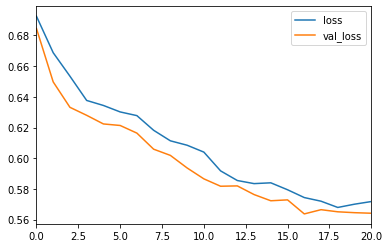

In [26]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

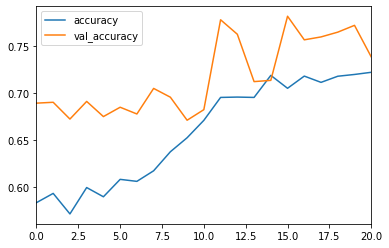

In [27]:
losses[['accuracy','val_accuracy']].plot()

In [28]:
print("roc of train set is {}".format(roc_auc_score(y_train_re,model.predict_proba(scaled_x_train))))
print("roc of test set is {}".format(roc_auc_score(y_test_re,model.predict_proba(scaled_x_test))))

roc of train set is 0.8120567042399344
roc of test set is 0.7939338712260503


## OVERSAMPLING WITH ANN

In [29]:
oversample=RandomOverSampler(sampling_strategy='minority')

In [30]:
x_over,y_over=oversample.fit_resample(x_train,y_train)
x_over=scaler.fit_transform(x_over)
y_over=np.array(y_over)

In [31]:
model = build_model()
model.fit(x_over,y_over,batch_size=batch_size,epochs=epochs,callbacks = [early_stopping],validation_data=(scaled_x_test,y_test_re)) 

Train on 116830 samples, validate on 15204 samples
Epoch 1/100
116830/116830 [==============================] - 8s 67us/sample - loss: 0.6614 - accuracy: 0.6029 - val_loss: 0.6378 - val_accuracy: 0.6928
Epoch 2/100
116830/116830 [==============================] - 3s 25us/sample - loss: 0.6221 - accuracy: 0.6764 - val_loss: 0.5602 - val_accuracy: 0.6842
Epoch 3/100
116830/116830 [==============================] - 2s 19us/sample - loss: 0.5918 - accuracy: 0.7066 - val_loss: 0.5622 - val_accuracy: 0.7060
Epoch 4/100
116830/116830 [==============================] - 2s 16us/sample - loss: 0.5745 - accuracy: 0.7246 - val_loss: 0.5153 - val_accuracy: 0.7485
Epoch 5/100
116830/116830 [==============================] - 2s 16us/sample - loss: 0.5620 - accuracy: 0.7359 - val_loss: 0.5304 - val_accuracy: 0.7256
Epoch 6/100
116830/116830 [==============================] - 2s 18us/sample - loss: 0.5546 - accuracy: 0.7391 - val_loss: 0.4789 - val_accuracy: 0.7722
Epoch 7/100
116830/116830 [==========

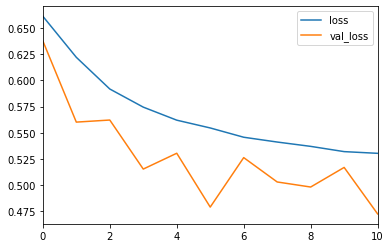

In [32]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

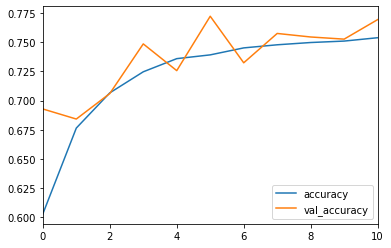

In [33]:
losses[['accuracy','val_accuracy']].plot()

Text(0.5, 1.0, 'ROC CURVE')

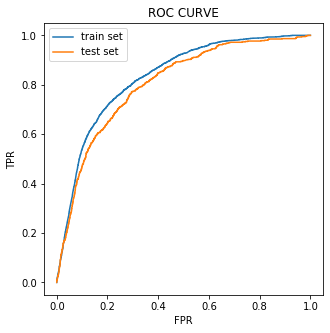

In [34]:
fpr,tpr,_=roc_curve(y_over,model.predict_proba(x_over))
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,label="train set")
fpr,tpr,_=roc_curve(y_test,model.predict_proba(scaled_x_test))
plt.plot(fpr,tpr,label="test set")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")

In [35]:
print("roc of train set is {}".format(roc_auc_score(y_over,model.predict_proba(x_over))))
print("roc of test set is {}".format(roc_auc_score(y_test_re,model.predict_proba(scaled_x_test))))

roc of train set is 0.8325473718923829
roc of test set is 0.8046610082932117


Train Data Confusion Matrix:

[[45508 12907]
 [15311 43104]]
              precision    recall  f1-score   support

           0       0.75      0.78      0.76     58415
           1       0.77      0.74      0.75     58415

    accuracy                           0.76    116830
   macro avg       0.76      0.76      0.76    116830
weighted avg       0.76      0.76      0.76    116830



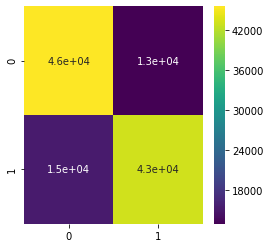

In [36]:
predictions = model.predict_classes(x_over)
print('Train Data Confusion Matrix:\n')
print(confusion_matrix(y_over,predictions))
print(classification_report(y_over,predictions))
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_over,predictions),cmap='viridis',annot=True)

Test Data Confusion Matrix:

[[11329  3268]
 [  196   411]]
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     14597
           1       0.11      0.68      0.19       607

    accuracy                           0.77     15204
   macro avg       0.55      0.73      0.53     15204
weighted avg       0.95      0.77      0.84     15204



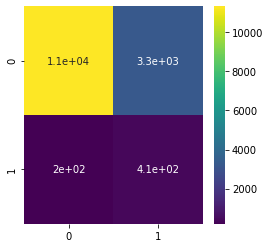

In [37]:
predictions = model.predict_classes(scaled_x_test)
print('Test Data Confusion Matrix:\n')
print(confusion_matrix(y_test_re,predictions))
print(classification_report(y_test_re,predictions))
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test_re,predictions),cmap='viridis',annot=True)

## UNDERSAMPLING WITH XGB

In [38]:
undersampler=RandomUnderSampler(sampling_strategy='majority')

In [39]:
x_under,y_under=undersampler.fit_resample(x_train,y_train)

In [40]:
x_under.shape

(4802, 202)

In [41]:
r1=xgb.XGBClassifier(n_estimators=250,learning_rate=0.05,colsample_bytree=0.5,colsample_bylevel=0.5,max_depth=3)
r1.fit(x_under,y_under,eval_set=[(x_under,y_under),(x_test,y_test)],early_stopping_rounds=6,eval_metric="auc")

[0]	validation_0-auc:0.77867	validation_1-auc:0.77224
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 6 rounds.
[1]	validation_0-auc:0.79908	validation_1-auc:0.78109
[2]	validation_0-auc:0.80060	validation_1-auc:0.78136
[3]	validation_0-auc:0.80096	validation_1-auc:0.78054
[4]	validation_0-auc:0.80707	validation_1-auc:0.79038
[5]	validation_0-auc:0.80590	validation_1-auc:0.78999
[6]	validation_0-auc:0.80535	validation_1-auc:0.79074
[7]	validation_0-auc:0.80620	validation_1-auc:0.79202
[8]	validation_0-auc:0.81070	validation_1-auc:0.79849
[9]	validation_0-auc:0.80998	validation_1-auc:0.79783
[10]	validation_0-auc:0.81134	validation_1-auc:0.79743
[11]	validation_0-auc:0.81054	validation_1-auc:0.79584
[12]	validation_0-auc:0.81332	validation_1-auc:0.79875
[13]	validation_0-auc:0.81410	validation_1-auc:0.80040
[14]	validation_0-auc:0.81510	validation_1-auc:0.80320
[15]	validation_0-auc:0.81491

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
confusion_matrix(y_test,r1.predict(x_test))

array([[11398,  3199],
       [  153,   454]], dtype=int64)

In [43]:
print("roc of test set is {}".format(roc_auc_score(y_test,r1.predict_proba(x_test)[:,1])))

roc of test set is 0.8360330297383441


## XGB, Random Forest , ADABoost and GradientBoost with GridSearch

In [44]:
scale_pos_weight=len(target[target==0])/len(target[target==1])
scale_pos_weight

24.272606382978722

In [45]:
r=xgb.XGBClassifier(n_estimators=250,learning_rate=0.05,colsample_bytree=0.5,colsample_bylevel=0.5,max_depth=3,scale_pos_weight=scale_pos_weight)
r.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],early_stopping_rounds=6,eval_metric="auc")

[0]	validation_0-auc:0.78080	validation_1-auc:0.77797
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 6 rounds.
[1]	validation_0-auc:0.79312	validation_1-auc:0.77851
[2]	validation_0-auc:0.80021	validation_1-auc:0.78323
[3]	validation_0-auc:0.79854	validation_1-auc:0.77902
[4]	validation_0-auc:0.80386	validation_1-auc:0.78488
[5]	validation_0-auc:0.80139	validation_1-auc:0.78080
[6]	validation_0-auc:0.80054	validation_1-auc:0.78224
[7]	validation_0-auc:0.80169	validation_1-auc:0.78404
[8]	validation_0-auc:0.80831	validation_1-auc:0.79274
[9]	validation_0-auc:0.80930	validation_1-auc:0.79389
[10]	validation_0-auc:0.80971	validation_1-auc:0.79409
[11]	validation_0-auc:0.81055	validation_1-auc:0.79376
[12]	validation_0-auc:0.81280	validation_1-auc:0.79857
[13]	validation_0-auc:0.81393	validation_1-auc:0.80103
[14]	validation_0-auc:0.81539	validation_1-auc:0.80394
[15]	validation_0-auc:0.81531

[146]	validation_0-auc:0.85618	validation_1-auc:0.83999
[147]	validation_0-auc:0.85628	validation_1-auc:0.83999
[148]	validation_0-auc:0.85639	validation_1-auc:0.84008
[149]	validation_0-auc:0.85645	validation_1-auc:0.84009
[150]	validation_0-auc:0.85650	validation_1-auc:0.84011
[151]	validation_0-auc:0.85659	validation_1-auc:0.84015
[152]	validation_0-auc:0.85663	validation_1-auc:0.84016
[153]	validation_0-auc:0.85666	validation_1-auc:0.84018
[154]	validation_0-auc:0.85670	validation_1-auc:0.84019
[155]	validation_0-auc:0.85674	validation_1-auc:0.84020
[156]	validation_0-auc:0.85679	validation_1-auc:0.84018
[157]	validation_0-auc:0.85689	validation_1-auc:0.84019
[158]	validation_0-auc:0.85693	validation_1-auc:0.84022
[159]	validation_0-auc:0.85699	validation_1-auc:0.84030
[160]	validation_0-auc:0.85709	validation_1-auc:0.84031
[161]	validation_0-auc:0.85717	validation_1-auc:0.84033
[162]	validation_0-auc:0.85722	validation_1-auc:0.84034
[163]	validation_0-auc:0.85728	validation_1-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=24.272606382978722,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [46]:
r=xgb.XGBClassifier(n_estimators=250,learning_rate=0.05,colsample_bytree=0.5,max_depth=3,scale_pos_weight=scale_pos_weight,
                             subsample=1,min_child_weight=1,gamma=0,reg_lambda=1).fit(x_train,y_train)
confusion_matrix(y_test,r.predict(x_test))

array([[11457,  3140],
       [  151,   456]], dtype=int64)

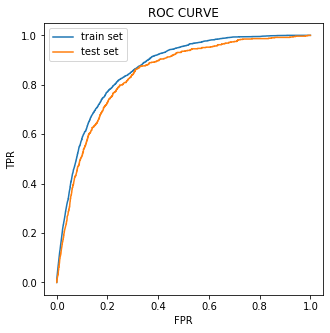

In [47]:
plot_roc(r,x_train,y_train,x_test,y_test)

In [48]:
clf=xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
params={"n_estimators":[15,25,35,45],"max_depth":[3,5],"learning_rate":[0.01,0.1,0.25],"colsample_bytree":[0.5,0.75,0.25]}
gs1=GridSearchCV(clf,param_grid=params,cv=3,scoring="roc_auc",verbose=500)
gs1.fit(x_train,y_train)
gs1.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=15 
[CV]  colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=15, score=0.799, total=   6.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=15 
[CV]  colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=15, score=0.815, total=   4.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=15 
[CV]  colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=15, score=0.802, total=   5.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.2s remaining:    0.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimator

[CV]  colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=35, score=0.838, total=   8.9s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  3.9min remaining:    0.0s
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=35 
[CV]  colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=35, score=0.838, total=   9.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  4.0min remaining:    0.0s
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=45 
[CV]  colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=45, score=0.826, total=  10.4s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  4.2min remaining:    0.0s
[CV] colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=45 
[CV]  colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=45, score=0.839, total=   5.2s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  4.3min remaining:    0.0s
[CV] colsample_bytree=0.5, learning_

[CV]  colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, score=0.817, total=   5.4s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  8.2min remaining:    0.0s
[CV] colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, score=0.832, total=   9.3s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  8.3min remaining:    0.0s
[CV] colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=25, score=0.838, total=   9.2s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:  8.5min remaining:    0.0s
[CV] colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=35 
[CV]  colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=35, score=0.813, total=   5.8s
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:  8.6min remaining:    0.0s
[CV] colsample_bytree=0.5, le

[CV]  colsample_bytree=0.75, learning_rate=0.01, max_depth=5, n_estimators=45, score=0.832, total=  14.4s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 13.3min remaining:    0.0s
[CV] colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=15 
[CV]  colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=15, score=0.820, total=   2.5s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed: 13.3min remaining:    0.0s
[CV] colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=15 
[CV]  colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=15, score=0.830, total=   6.7s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed: 13.5min remaining:    0.0s
[CV] colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=15 
[CV]  colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=15, score=0.832, total=   7.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed: 13.6min remaining:    0.0s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, learning_rate=0.25, max_depth=3, n_estimators=35, score=0.836, total=  10.5s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed: 18.0min remaining:    0.0s
[CV] colsample_bytree=0.75, learning_rate=0.25, max_depth=3, n_estimators=35 
[CV]  colsample_bytree=0.75, learning_rate=0.25, max_depth=3, n_estimators=35, score=0.838, total=  10.2s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed: 18.1min remaining:    0.0s
[CV] colsample_bytree=0.75, learning_rate=0.25, max_depth=3, n_estimators=45 
[CV]  colsample_bytree=0.75, learning_rate=0.25, max_depth=3, n_estimators=45, score=0.824, total=  11.8s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed: 18.3min remaining:    0.0s
[CV] colsample_bytree=0.75, learning_rate=0.25, max_depth=3, n_estimators=45 
[CV]  colsample_bytree=0.75, learning_rate=0.25, max_depth=3, n_estimators=45, score=0.834, total=  11.3s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed: 18.5min remaining:    0.0s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.25, learning_rate=0.01, max_depth=5, n_estimators=25, score=0.798, total=   7.6s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 22.5min remaining:    0.0s
[CV] colsample_bytree=0.25, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.25, learning_rate=0.01, max_depth=5, n_estimators=25, score=0.825, total=   7.5s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed: 22.6min remaining:    0.0s
[CV] colsample_bytree=0.25, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.25, learning_rate=0.01, max_depth=5, n_estimators=25, score=0.811, total=   7.6s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 22.7min remaining:    0.0s
[CV] colsample_bytree=0.25, learning_rate=0.01, max_depth=5, n_estimators=35 
[CV]  colsample_bytree=0.25, learning_rate=0.01, max_depth=5, n_estimators=35, score=0.802, total=   8.7s
[Parallel(n_jobs=1)]: Done 163 out of 163 | elapsed: 22.9min remaining:    0.0s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.25, learning_rate=0.1, max_depth=5, n_estimators=45, score=0.836, total=   9.9s
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 26.4min remaining:    0.0s
[CV] colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=15 
[CV]  colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=15, score=0.819, total=   4.9s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed: 26.5min remaining:    0.0s
[CV] colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=15 
[CV]  colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=15, score=0.837, total=   5.3s
[Parallel(n_jobs=1)]: Done 194 out of 194 | elapsed: 26.6min remaining:    0.0s
[CV] colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=15 
[CV]  colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=15, score=0.829, total=   5.3s
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed: 26.6min remaining:    0.0s
[CV] colsample_bytree=0

{'colsample_bytree': 0.5,
 'learning_rate': 0.25,
 'max_depth': 3,
 'n_estimators': 25}

[12:56:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_Depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Unoptimized model
------
AUPRC on test data: 0.1057
AUROC on test data: 0.7331
F-score on test data: 0.5475

Optimized Model
------
Final AUPRC on the test data: 0.1063
Final AUROC the test data: 0.7519
Final F-score on the test data: 0.5917
test data confusion matrix:

[[11995  2602]
 [  193   414]]
Area Under ROC Curve for test data:  0.8318327015131068


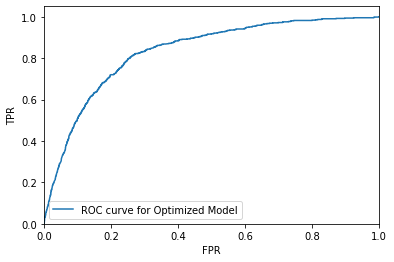

In [49]:
r2=xgb.XGBClassifier(n_estimators=25,max_Depth=3,learning_rate=0.25,colsample_bytree=0.5,scale_pos_weight=scale_pos_weight).fit(x_train,y_train)
#predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_test)
best_predictions = r2.predict(x_test)
# score before optimization 
print ("Unoptimized model\n------")
print ("AUPRC on test data: {:.4f}".format(average_precision_score(y_test, predictions)))
print ("AUROC on test data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print ("F-score on test data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the test data: {:.4f}".format(average_precision_score(y_test, best_predictions)))
print ("Final AUROC the test data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print ("Final F-score on the test data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 5)))
print('test data confusion matrix:\n')
print(confusion_matrix(y_test,best_predictions))

probas_ = r2.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve for test data: ",area)
#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

In [50]:
clf = RandomForestClassifier(random_state=42,class_weight=class_weight)

# parameters to tune

parameters = {
              'max_features': [0.5,0.75],
              'max_depth':[8,12,15],
              "n_estimators":[100,200,300,400]
              }


# grid search using roc score
gs2 = GridSearchCV(clf, parameters, scoring="roc_auc",cv=3,verbose=1000)

# fit grid search
gs2.fit(x_train, y_train)

# best estimator
gs2.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=8, max_features=0.5, n_estimators=100 .................
[CV]  max_depth=8, max_features=0.5, n_estimators=100, score=0.819, total= 1.3min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[CV] max_depth=8, max_features=0.5, n_estimators=100 .................
[CV]  max_depth=8, max_features=0.5, n_estimators=100, score=0.830, total= 1.3min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=8, max_features=0.5, n_estimators=100 .................
[CV]  max_depth=8, max_features=0.5, n_estimators=100, score=0.838, total= 1.3min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s
[CV] max_depth=8, max_features=0.5, n_estimators=200 .................
[CV]  max_depth=8, max_features=0.5, n_estimators=200, score=0.819, total= 2.6min
[Paral

[CV]  max_depth=12, max_features=0.5, n_estimators=400, score=0.830, total= 7.1min
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 151.8min remaining:    0.0s
[CV] max_depth=12, max_features=0.75, n_estimators=100 ...............
[CV]  max_depth=12, max_features=0.75, n_estimators=100, score=0.808, total= 2.5min
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 154.4min remaining:    0.0s
[CV] max_depth=12, max_features=0.75, n_estimators=100 ...............
[CV]  max_depth=12, max_features=0.75, n_estimators=100, score=0.815, total= 2.5min
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 156.9min remaining:    0.0s
[CV] max_depth=12, max_features=0.75, n_estimators=100 ...............
[CV]  max_depth=12, max_features=0.75, n_estimators=100, score=0.827, total= 2.5min
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 159.5min remaining:    0.0s
[CV] max_depth=12, max_features=0.75, n_estimators=200 ...............
[CV]  max_depth=12, max_features=0.75, n_estimators=200, 

[CV]  max_depth=15, max_features=0.75, n_estimators=400, score=0.814, total=11.8min
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed: 364.7min remaining:    0.0s
[CV] max_depth=15, max_features=0.75, n_estimators=400 ...............
[CV]  max_depth=15, max_features=0.75, n_estimators=400, score=0.825, total=11.4min
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 376.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 376.0min finished


{'max_depth': 8, 'max_features': 0.5, 'n_estimators': 300}

Unoptimized model
------
AUPRC on test data: 0.0506
AUROC on test data: 0.5394
F-score on test data: 0.1065

Optimized Model
------
Final AUPRC on the test data: 0.1069
Final AUROC the test data: 0.7478
Final F-score on the test data: 0.5809
test data confusion matrix:

[[12139  2458]
 [  204   403]]
Area Under ROC Curve for test data:  0.8375650183812678


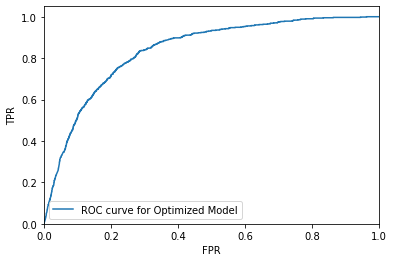

In [51]:
#fitting the classifier with best parameters obtained
r3=RandomForestClassifier(max_depth=8, max_features=.5, n_estimators=300,random_state=42,class_weight=class_weight).fit(x_train,y_train)

#predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_test)
best_predictions = r3.predict(x_test)
# score before optimization 
print ("Unoptimized model\n------")
print ("AUPRC on test data: {:.4f}".format(average_precision_score(y_test, predictions)))
print ("AUROC on test data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print ("F-score on test data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the test data: {:.4f}".format(average_precision_score(y_test, best_predictions)))
print ("Final AUROC the test data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print ("Final F-score on the test data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 5)))
print('test data confusion matrix:\n')
print(confusion_matrix(y_test,best_predictions))

probas_ = r3.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve for test data: ",area)
#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

In [52]:
clf=AdaBoostClassifier()
params={"n_estimators":[200,300,400],"learning_rate":[0.05,0.1,0.2]}
gs3=GridSearchCV(clf,param_grid=params,cv=3,scoring="roc_auc",verbose=500)
gs3.fit(x_train,y_train)
gs3.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.05, n_estimators=200 ............................
[CV]  learning_rate=0.05, n_estimators=200, score=0.821, total= 2.5min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[CV] learning_rate=0.05, n_estimators=200 ............................
[CV]  learning_rate=0.05, n_estimators=200, score=0.830, total= 2.4min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.05, n_estimators=200 ............................
[CV]  learning_rate=0.05, n_estimators=200, score=0.832, total= 2.4min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.3min remaining:    0.0s
[CV] learning_rate=0.05, n_estimators=300 ............................
[CV]  learning_rate=0.05, n_estimators=300, score=0.822, total= 3.5min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

{'learning_rate': 0.05, 'n_estimators': 400}

Unoptimized model
------
AUPRC on test data: 0.0410
AUROC on test data: 0.5022
F-score on test data: 0.0051

Optimized Model
------
Final AUPRC on the test data: 0.0418
Final AUROC the test data: 0.5023
Final F-score on the test data: 0.0051
Area Under ROC Curve for test data:  0.8249744734395674


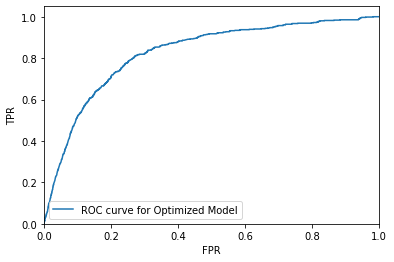

In [53]:
#fitting the classifier with best parameters obtained
r4=AdaBoostClassifier(learning_rate=0.05,n_estimators=400).fit(x_train,y_train)

#predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_test)
best_predictions = r4.predict(x_test)
# score before optimization 
print ("Unoptimized model\n------")
print ("AUPRC on test data: {:.4f}".format(average_precision_score(y_test, predictions)))
print ("AUROC on test data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print ("F-score on test data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the test data: {:.4f}".format(average_precision_score(y_test, best_predictions)))
print ("Final AUROC the test data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print ("Final F-score on the test data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 5)))

probas_ = r4.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve for test data: ",area)
#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

In [54]:
clf=GradientBoostingClassifier(subsample=0.75)
params={"n_estimators":[200,300,400],"learning_rate":[0.05,0.1,0.2],"max_features":[0.5],"max_depth":[3,5]}
gs4=GridSearchCV(clf,param_grid=params,cv=3,scoring="roc_auc",verbose=500)
gs4.fit(x_train,y_train)
gs4.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=200, score=0.825, total= 1.3min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=200, score=0.839, total= 1.3min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=200, score=0.838, total= 1.3min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=300 
[CV]  learning_r

[CV]  learning_rate=0.1, max_depth=5, max_features=0.5, n_estimators=300, score=0.830, total= 3.1min
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 79.1min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=5, max_features=0.5, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=5, max_features=0.5, n_estimators=400, score=0.804, total= 4.2min
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 83.3min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=5, max_features=0.5, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=5, max_features=0.5, n_estimators=400, score=0.823, total= 4.1min
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 87.4min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=5, max_features=0.5, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=5, max_features=0.5, n_estimators=400, score=0.827, total= 4.0min
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 91.4min remaining:    0.0s
[CV] learning_rate=0.2, max_depth=3, max_features=0.5, n_

{'learning_rate': 0.05,
 'max_depth': 3,
 'max_features': 0.5,
 'n_estimators': 400}

Unoptimized model
------
AUPRC on test data: 0.0412
AUROC on test data: 0.5022
F-score on test data: 0.0051

Optimized Model
------
Final AUPRC on the test data: 0.0416
Final AUROC the test data: 0.5070
Final F-score on the test data: 0.0204
Area Under ROC Curve for test data:  0.8038252088313604


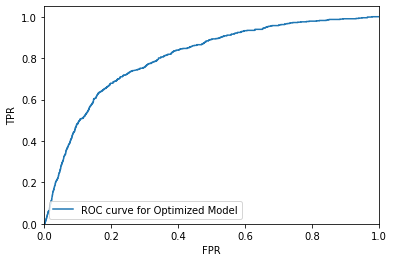

In [55]:
#fitting the classifier with best parameters obtained
r5=GradientBoostingClassifier(n_estimators=400,learning_rate=0.2,max_features=0.5,max_depth=5).fit(x_train,y_train)

#predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_test)
best_predictions = r5.predict(x_test)
# score before optimization 
print ("Unoptimized model\n------")
print ("AUPRC on test data: {:.4f}".format(average_precision_score(y_test, predictions)))
print ("AUROC on test data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print ("F-score on test data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the test data: {:.4f}".format(average_precision_score(y_test, best_predictions)))
print ("Final AUROC the test data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print ("Final F-score on the test data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 5)))

probas_ = r5.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve for test data: ",area)
#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

## ENSEMBLE : VOTING CLASSIFIER (SOFT VOTING)

In [56]:
clf=VotingClassifier(estimators=[("XGB",r2),('RF',r3)],voting="soft").fit(x_train,y_train)
confusion_matrix(y_test,clf.predict(x_test))

[23:47:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_Depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




array([[12099,  2498],
       [  194,   413]], dtype=int64)

In [58]:
#submission based on soft voting
predictions=clf.predict(test[x_train.columns])
submission=pd.DataFrame({'ID':test_id,'TARGET':predictions}).set_index('ID')
submission.to_csv('Santander_Bank.csv')